<a href="https://colab.research.google.com/github/Aditi0004/fraud-detection/blob/main/Copy_of_Untitled10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
#https://drive.google.com/file/d/1HjUUqGo2vryAWoxc3v2WlFlEZLGTPR_a/view?usp=sharing
import gdown

def load_csv_into_sqlite(csv_file='onlinefraud.csv', db_name='fraud_detection.db', table_name='fraud_data'):

    data = pd.read_csv(csv_file)

    # Connect to SQLite database
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    # Save CSV data into SQLite
    data.to_sql(table_name, conn, if_exists='replace', index=False)

    # Check if data was loaded successfully
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    count = cursor.fetchone()[0]

    conn.commit()
    conn.close()

    if count > 0:
        print(f"Success: {count} records loaded into '{table_name}' from '{csv_file}'")
    else:
        print(f"Error: No data found in '{table_name}' after loading.")

# Google Drive file ID (replace with your actual file ID)
file_id = "1HjUUqGo2vryAWoxc3v2WlFlEZLGTPR_a"
csv_file = "onlinefraud.csv"
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
gdown.download(url, csv_file, quiet=False)

# Load data into SQLite
load_csv_into_sqlite(csv_file=csv_file)

Downloading...
From (original): https://drive.google.com/uc?id=1HjUUqGo2vryAWoxc3v2WlFlEZLGTPR_a
From (redirected): https://drive.google.com/uc?id=1HjUUqGo2vryAWoxc3v2WlFlEZLGTPR_a&confirm=t&uuid=69d3f523-a12c-404d-81f5-e0751e6b5cb5
To: /content/onlinefraud.csv
100%|██████████| 494M/494M [00:07<00:00, 67.9MB/s]


Success: 6362620 records loaded into 'fraud_data' from 'onlinefraud.csv'


In [ ]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Database and table details
DB_NAME = 'fraud_detection.db'
TABLE_NAME = 'fraud_data'
RESULTS_TABLE = 'fraud_results'
BATCH_SIZE = 5000  # Number of records processed at a time

# Connect to SQLite and get total records
conn = sqlite3.connect(DB_NAME)
query_count = f"SELECT COUNT(*) FROM {TABLE_NAME}"
total_records = pd.read_sql(query_count, conn).iloc[0, 0]
conn.close()

# Initialize scaler and models
scaler = StandardScaler()
ocsvm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
isolation_forest = IsolationForest(contamination=0.1, random_state=42)

first_batch = True  # Track first batch for scaling

# Process data in batches
for offset in range(0, total_records, BATCH_SIZE):
    conn = sqlite3.connect(DB_NAME)

    # Fetch batch of data
    query = f"""
        SELECT step, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, isFraud, rowid
        FROM {TABLE_NAME}
        LIMIT {BATCH_SIZE} OFFSET {offset}
    """
    data_batch = pd.read_sql(query, conn)
    conn.close()

    if data_batch.empty:
        break  # Stop if no more data

    # Separate features (X) and target variable (y)
    X_batch = data_batch[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
    y_batch = data_batch['isFraud']

    # Train-test split within the batch
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X_batch, y_batch, data_batch['rowid'], test_size=0.2, random_state=42
    )

    # Scale data
    if first_batch:
        X_train = scaler.fit_transform(X_train)
        first_batch = False  # Ensure fit() is called only once
    else:
        X_train = scaler.transform(X_train)

    X_test = scaler.transform(X_test)  # Always transform test data

    # Train models
    ocsvm.fit(X_train[y_train == 0])  # Train only on non-fraudulent data
    isolation_forest.fit(X_train)

    # Predict
    ocsvm_pred = ocsvm.predict(X_test)
    isolation_forest_pred = isolation_forest.predict(X_test)

    # Convert predictions to binary (0 = normal, 1 = fraud)
    ocsvm_pred = [1 if i == -1 else 0 for i in ocsvm_pred]
    isolation_forest_pred = [1 if i == -1 else 0 for i in isolation_forest_pred]

    # Store results
    results = pd.DataFrame({
        'rowid': idx_test,
        'isFlaggedFraud_OCSVM': ocsvm_pred,
        'isFlaggedFraud_IF': isolation_forest_pred
    })

    # Save results back to SQLite
    conn = sqlite3.connect(DB_NAME)
    results.to_sql(RESULTS_TABLE, conn, if_exists='append', index=False)
    conn.close()

    print(f"Processed batch {offset // BATCH_SIZE + 1} / {total_records // BATCH_SIZE + 1}")

print("Batch training completed!")

# Evaluate the last batch (optional, for analysis)
print("\nOne-Class SVM:")
print(classification_report(y_test, ocsvm_pred))
print(confusion_matrix(y_test, ocsvm_pred))

print("\nIsolation Forest:")
print(classification_report(y_test, isolation_forest_pred))
print(confusion_matrix(y_test, isolation_forest_pred))


Processed batch 1 / 1273
Processed batch 2 / 1273
Processed batch 3 / 1273
Processed batch 4 / 1273
Processed batch 5 / 1273
Processed batch 6 / 1273
Processed batch 7 / 1273
Processed batch 8 / 1273
Processed batch 9 / 1273
Processed batch 10 / 1273
Processed batch 11 / 1273
Processed batch 12 / 1273
Processed batch 13 / 1273
Processed batch 14 / 1273
Processed batch 15 / 1273
Processed batch 16 / 1273
Processed batch 17 / 1273
Processed batch 18 / 1273
Processed batch 19 / 1273
Processed batch 20 / 1273
Processed batch 21 / 1273
Processed batch 22 / 1273
Processed batch 23 / 1273
Processed batch 24 / 1273
Processed batch 25 / 1273
Processed batch 26 / 1273
Processed batch 27 / 1273
Processed batch 28 / 1273
Processed batch 29 / 1273
Processed batch 30 / 1273
Processed batch 31 / 1273
Processed batch 32 / 1273
Processed batch 33 / 1273
Processed batch 34 / 1273
Processed batch 35 / 1273
Processed batch 36 / 1273
Processed batch 37 / 1273
Processed batch 38 / 1273
Processed batch 39 / 

<ipython-input-4-f0a99d588a62>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fraud_Detected', data=data_test, palette={'0': "green", '1': "red"})


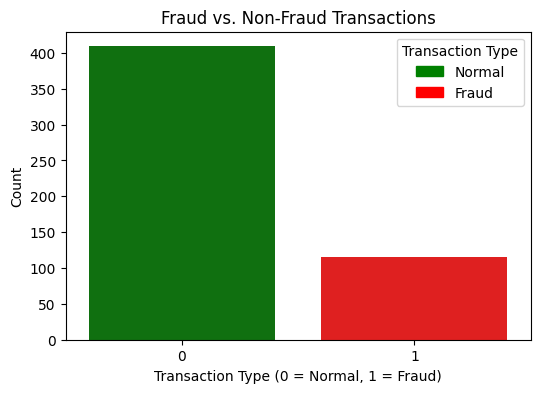

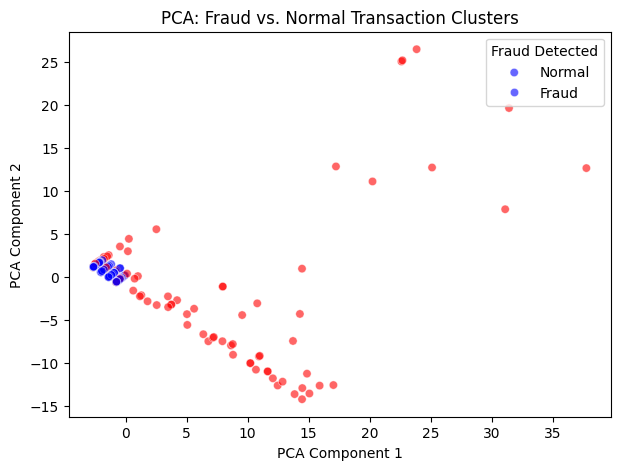

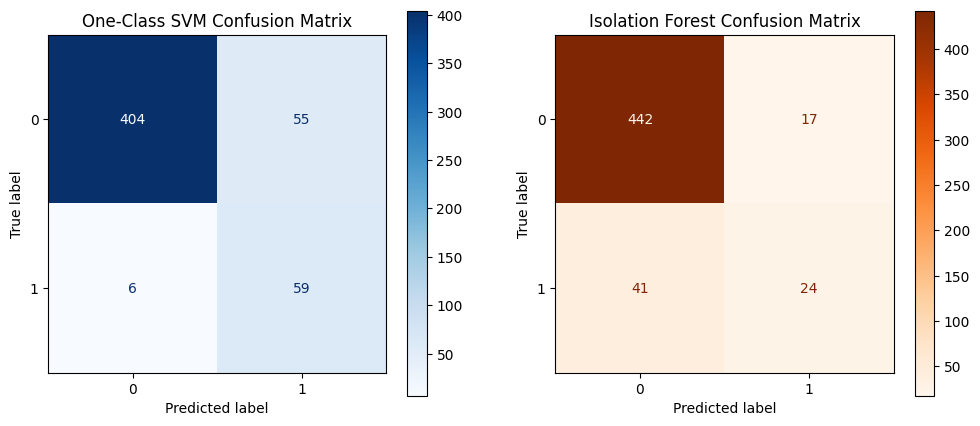

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.patches import Patch

# Ensure `Fraud_Detected` is calculated properly
ocsvm_pred = np.array(ocsvm_pred)
isolation_forest_pred = np.array(isolation_forest_pred)

# Recreate `data_test` with original column names from `data`
data_test = data_batch.iloc[y_test.index].copy()
data_test['Fraud_Detected'] = (ocsvm_pred + isolation_forest_pred) >= 1
data_test['Fraud_Detected'] = data_test['Fraud_Detected'].astype(int)

# 1. **Bar Chart of Fraud vs. Non-Fraud Transactions**
plt.figure(figsize=(6, 4))
sns.countplot(x='Fraud_Detected', data=data_test, palette={'0': "green", '1': "red"})

# Manually create a custom legend
legend_labels = [Patch(color="green", label="Normal"), Patch(color="red", label="Fraud")]
plt.legend(handles=legend_labels, title="Transaction Type")

plt.title("Fraud vs. Non-Fraud Transactions")
plt.xlabel("Transaction Type (0 = Normal, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

# 2. **PCA Visualization of Fraud Clusters**
pca = PCA(n_components=2)  # Reduce to 2D
X_reduced = pca.fit_transform(X_test)

plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=data_test['Fraud_Detected'], palette={0: "blue", 1: "red"}, alpha=0.6)

plt.title("PCA: Fraud vs. Normal Transaction Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Fraud Detected", labels=["Normal", "Fraud"])
plt.show()

# 3. **Confusion Matrix Heatmap**
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# One-Class SVM Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, ocsvm_pred, ax=axes[0], cmap="Blues")
axes[0].set_title("One-Class SVM Confusion Matrix")

# Isolation Forest Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, isolation_forest_pred, ax=axes[1], cmap="Oranges")
axes[1].set_title("Isolation Forest Confusion Matrix")

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import joblib
import os

# Define the save path in Google Drive
drive_path = "/content/drive/My Drive/fraud_detection_models"
os.makedirs(drive_path, exist_ok=True)  # Create directory if it doesn't exist

# Save One-Class SVM model
joblib.dump(ocsvm, os.path.join(drive_path, "one_class_svm.joblib"))

# Save Isolation Forest model
joblib.dump(isolation_forest, os.path.join(drive_path, "isolation_forest.joblib"))

print("Models saved successfully in Google Drive!")


Models saved successfully in Google Drive!
